# rozpoznawanie typów zgłoszeń DOP

In [1]:
import sys, os, re, time
import pandas as pd
import numpy as np
#import seaborn as sn
import matplotlib.pyplot as plt

# import random
# from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.feature_selection import SelectKBest
# from sklearn.feature_selection import f_classif
# from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import hamming_loss
from sklearn.model_selection import KFold

#from imblearn.over_sampling import RandomOverSampler

import fastText



## przygotowanie danych uczących

In [2]:
datapath='/mnt/c/dev/DOP-categories/'
datafile='Cases categorization.xlsx'
dane_surowe=pd.read_excel(os.path.join(datapath,datafile))


In [3]:
#dane_surowe.info()

In [4]:
dane_surowe.columns

Index(['casenumber', 'jira', 'contactemail', 'origin', 'status', '_type',
       'record_name', 'record_desc', 'createddate', 'lastmodifieddate',
       'closeddate', 'moneyrefund', 'owner_name', 'lastmod_name', 'case_desc',
       'tags'],
      dtype='object')

In [5]:
input_data=pd.DataFrame()
input_data[['content','category']]=dane_surowe[['case_desc','tags']]

In [6]:
input_data.head()

,content,category
0,Problem z wyświetlaniem informacji w FAQ - w ...,FAQ; wrong copy;
1,W żadnej z kategorii nie ma sekcji 'najczęstsz...,FAQ; content categorization;
2,moje konto> mój plan > szczegóły oferty aplika...,app crashes
3,Klient zgłsza problem z wyborem numerów. Przy ...,UX
4,Klienta nie może p.rzejść przez weryfikację nu...,OTP


In [8]:
# clearing data
# remove duplicates
input_data.drop_duplicates(inplace=True)
# remove empty
input_data=input_data.dropna()

In [9]:
# find duplicates
input_data[input_data.duplicated(keep=False)]

,content,category


## label freq analysis & selection

In [10]:
def parse_labels(raw_labels):
    label_list=raw_labels.split(';')
    label_list=[x.strip().replace(' ','_') for x in label_list if x != '']
    return label_list


In [11]:
label_lists=input_data['category'].apply(parse_labels)

In [12]:
label_lists.head()

0                [FAQ, wrong_copy]
1    [FAQ, content_categorization]
2                    [app_crashes]
3                             [UX]
4                            [OTP]
Name: category, dtype: object

In [13]:
from itertools import chain
from collections import Counter
label_count=Counter(chain.from_iterable(label_lists.values))

<BarContainer object of 112 artists>

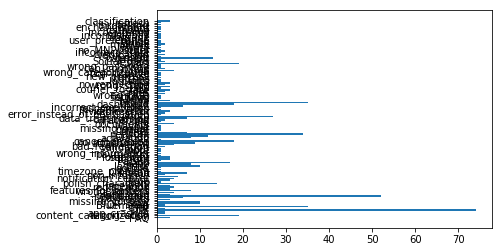

In [14]:
plt.barh(list(label_count.keys()),list(label_count.values()))

In [15]:
min_label_freq=5  # minimum occurencies to be used in 
pruned_label_count = {key:value for (key,value) in label_count.items() if value>=min_label_freq}

<BarContainer object of 27 artists>

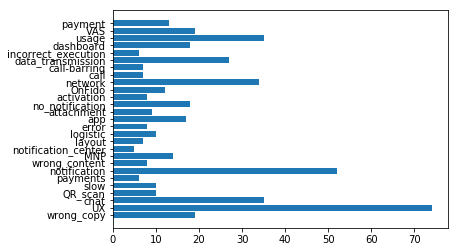

In [16]:
plt.barh(list(pruned_label_count.keys()),list(pruned_label_count.values()))

In [17]:
interesting_labels=list(pruned_label_count.keys())
pd.Series(interesting_labels).to_csv(os.path.join(datapath,'interesting_labels.csv'),header=['label'],index=False)


## preprocessing

### preprocessing content text

In [18]:
# Słownik synonimów / podmian

podmiany=pd.read_excel(os.path.join(datapath,'preproc_dict.xlsx'))

In [19]:
def preprocess_texts(raw_texts,replacements):
    """
    texts: np.Series containing strings to be preprocessed
    replacements: pairs of what convert to what
    return np.Series with corrected texts
    """
    resulttext=raw_texts.str.lower()
    for [co,naco,_] in replacements.values:
        resulttext=resulttext.str.replace(re.compile(str(co)),str(naco))
    return resulttext


In [20]:
prep_texts=preprocess_texts(input_data['content'],podmiany)

In [21]:
prep_texts[0]

'problem z wyświetlaniem informacji w faq w kategorii faq ogólne pierwszy artykuł ma tytuł tytuł dokumentu i treść przykładowy konwent dokumentu login _email msisdn _phonenumber numer zamówienia _number wystąpiło _number _number _number _number _number jira dsd _number'

### preprocessing labels

In [22]:
interesting_labels=pd.read_csv(os.path.join(datapath,'interesting_labels.csv'))

In [23]:
def preprocess_labels(raw_labels, interesting_labels):
    result_labels=raw_labels.split(';')  # split on ';'
    # remove leading space and replace spaces inside to underscore
    result_labels=[x.strip().replace(' ','_') for x in result_labels]
    #remove not interesting labels
    result_labels=[x for x in result_labels if x in interesting_labels]
    return result_labels

In [24]:

prep_labels=input_data['category'].apply(preprocess_labels, args=(interesting_labels.values,))

In [25]:
prep_labels.tail()

282    [chat, UX, slow, attachment]
283                        [OnFido]
284                         [usage]
285                         [usage]
286      [notification, wrong_copy]
Name: category, dtype: object

## model learning - fasttext

In [25]:
# texts_train,texts_val,y_train,y_val=train_test_split(prep_texts.values, prep_labels.values,
#                                                      test_size=0.25,random_state=1, shuffle=True)

In [26]:
#save file for fasttext emb
# pd.Series(texts_train).to_csv(os.path.join(datapath,'texts_for_emb.txt'),sep='\n',index=False)

In [27]:
# oversampling to boost minority classes
# ros = RandomOverSampler(random_state=0)

# texts_train, y_train = ros.fit_resample(np.reshape(texts_train, (-1, 1)),y_train)

# shuffle to be sure 
# texts_train, y_train = shuffle(texts_train, y_train, random_state=0)

# texts_train=texts_train.reshape(-1)

In [26]:
# prepare files for fasstext
def prepare_fasttext(texts, labels):
    fasttext_set=[]
    for i,l in enumerate(labels):
        l=['__label__'+x for x in l]
        labs=' '.join(l) 
        fasttext_set.append(labs + ' ' + texts[i])
    return fasttext_set

def prepare_fasttext_file(texts, labels, filename):
    fasttext_set=prepare_fasttext(texts, labels)
    pd.Series(fasttext_set).to_csv(os.path.join(datapath,filename),sep='\n',index=False)


In [27]:
# training & evaluation
def train_and_evaluate(texts, labels, params):
    print(params)
    avg_precision = avg_recall = 0
    fold_n=4
    folds = KFold(n_splits=fold_n, shuffle=True, random_state=1)
    for i, (train_index, val_index) in enumerate(folds.split(texts)):
        tic=time.time()
        print(f'Calculating fold {i+1}/{fold_n}...')
        # Generate batches from indices
        texts_train, texts_val = texts[train_index], texts[val_index]
        y_train, y_val = labels[train_index], labels[val_index]
        # prepare files for train and validation
        prepare_fasttext_file(texts_train, y_train, 'fasttext_train.txt')
        prepare_fasttext_file(texts_val, y_val, 'fasttext_val.txt')
        # train classifier
        classifier = fastText.train_supervised(os.path.join(datapath,'fasttext_train.txt'), **params)
        # test classifier
        supp,precision,recall=classifier.test(os.path.join(datapath,'fasttext_val.txt'), k=2)
        f1=2*precision*recall/(precision+recall)
        print(f'precision={precision:.2}, recall={recall:.2}, f1={f1:.2}')
        avg_precision+=precision/fold_n
        avg_recall+=recall/fold_n
        toc=time.time()
        # print(f'Fold {i+1} calcutated in {toc-tic}.')
    avg_f1=2*avg_precision*avg_recall/(avg_precision+avg_recall)
    print(f'** Average results: precision={avg_precision:.2}, recall={avg_recall:.2}, f1={avg_f1:.2}')
    return avg_precision, avg_recall, avg_f1
    

In [64]:
train_and_evaluate(prep_texts.values, prep_labels.values, {'epoch':10000, 'dim':50, 'wordNgrams':1, 'lr':0.5})

{'epoch': 10000, 'dim': 50, 'wordNgrams': 1, 'lr': 0.5}
Calculating fold 1/4...
precision=0.49, recall=0.54, f1=0.52
Calculating fold 2/4...
precision=0.46, recall=0.52, f1=0.49
Calculating fold 3/4...
precision=0.44, recall=0.5, f1=0.47
Calculating fold 4/4...
precision=0.53, recall=0.54, f1=0.53
** Average results: precision=0.48, recall=0.52, f1=0.5


(0.483156804388422, 0.5239309348148878, 0.5027184550685827)

In [48]:
def hyperparameters_grid_search():
    # search space
    epoch_list=[6000]
    dim_list=[20,30,40,60,80,110]
    wordNgrams_list=[1]
    bucket_list=[2000000]
    lr_list=[0.3,1]
    # results
    results=[]
    for epoch, dim, wordNgrams, bucket, lr in [(epoch, dim, wordNgrams, bucket, lr) for epoch in epoch_list 
                                  for dim in dim_list for wordNgrams in wordNgrams_list
                                  for bucket in bucket_list for lr in lr_list]:
        params={'epoch':epoch, 'dim':dim, 'wordNgrams':wordNgrams, 'bucket':bucket, 'lr':lr}
        precision, recall, f1 = train_and_evaluate(prep_texts.values, prep_labels.values, params)
        results.append([epoch, dim, wordNgrams, bucket, lr, precision, recall, f1])
    grid=pd.DataFrame(results, columns=['epoch', 'dim', 'wordNgrams', 'bucket', 'lr', 'precision', 'recall', 'f1'])
    grid.to_csv(os.path.join(datapath,'grid_results.csv'),index=False)
    return results


In [49]:
hyperparameters_grid_search()

{'epoch': 6000, 'dim': 20, 'wordNgrams': 1, 'bucket': 2000000, 'lr': 0.3}
Calculating fold 1/4...
precision=0.49, recall=0.54, f1=0.52
Calculating fold 2/4...
precision=0.48, recall=0.54, f1=0.51
Calculating fold 3/4...
precision=0.43, recall=0.48, f1=0.45
Calculating fold 4/4...
precision=0.48, recall=0.49, f1=0.49
** Average results: precision=0.47, recall=0.51, f1=0.49
{'epoch': 6000, 'dim': 20, 'wordNgrams': 1, 'bucket': 2000000, 'lr': 1}
Calculating fold 1/4...
precision=0.48, recall=0.53, f1=0.5
Calculating fold 2/4...
precision=0.47, recall=0.53, f1=0.5
Calculating fold 3/4...
precision=0.46, recall=0.51, f1=0.49
Calculating fold 4/4...
precision=0.52, recall=0.52, f1=0.52
** Average results: precision=0.48, recall=0.52, f1=0.5
{'epoch': 6000, 'dim': 30, 'wordNgrams': 1, 'bucket': 2000000, 'lr': 0.3}
Calculating fold 1/4...
precision=0.49, recall=0.54, f1=0.51
Calculating fold 2/4...
precision=0.47, recall=0.53, f1=0.5
Calculating fold 3/4...
precision=0.44, recall=0.49, f1=0.46

[[6000,
  20,
  1,
  2000000,
  0.3,
  0.47104122899159667,
  0.5116951324317787,
  0.49052729401521405],
 [6000,
  20,
  1,
  2000000,
  1,
  0.48132805205415496,
  0.5223536650515275,
  0.5010023950772566],
 [6000,
  30,
  1,
  2000000,
  0.3,
  0.4752607813958917,
  0.51578051329813,
  0.49469230210942106],
 [6000,
  30,
  1,
  2000000,
  1,
  0.48141193977591035,
  0.5220457632198091,
  0.5009061423778137],
 [6000,
  40,
  1,
  2000000,
  0.3,
  0.476702191293184,
  0.5173882548622712,
  0.4962126249096486],
 [6000,
  40,
  1,
  2000000,
  1,
  0.4762626925770308,
  0.516713403162183,
  0.4956641307612974],
 [6000,
  60,
  1,
  2000000,
  0.3,
  0.4865918242296919,
  0.528206316321403,
  0.506545813907187],
 [6000,
  60,
  1,
  2000000,
  1,
  0.48539186507936505,
  0.526388233901153,
  0.5050594825230567],
 [6000,
  80,
  1,
  2000000,
  0.3,
  0.4764414098972922,
  0.5172724021951389,
  0.4960180478600159],
 [6000,
  80,
  1,
  2000000,
  1,
  0.47767310049019607,
  0.51807725928

## final model training

In [65]:
# training
best_params = {'epoch':10000, 'dim':40, 'wordNgrams':1, 'lr':0.5}
prepare_fasttext_file(prep_texts.values, prep_labels.values, 'fasttext_final_train.txt')
classifier = fastText.train_supervised(os.path.join(datapath,'fasttext_final_train.txt'),**best_params)

In [66]:
supp,precision,recall=classifier.test(os.path.join(datapath,'fasttext_final_train.txt'), k=2)
f1=2*precision*recall/(precision+recall)
print(f'Final model (on TRAIN data): precision={precision:.2}, recall={recall:.2}, f1={f1:.2}')

Final model (on TRAIN data): precision=0.84, recall=0.92, f1=0.88


In [67]:
# save finam model to file
classifier.save_model(os.path.join(datapath,'model'))
# use predict.py for predictions

# ------------- backup code -------------------------

In [34]:
assert False # stop code execution here

AssertionError: 

## result analysis

In [68]:
def hamming_score(y_true, y_pred, normalize=True, sample_weight=None):
    '''
    Compute the Hamming score (a.k.a. label-based accuracy) for the multi-label case
    http://stackoverflow.com/q/32239577/395857
    '''
    acc_list = []
    for i in range(y_true.shape[0]):
        set_true = set( np.where(y_true[i])[0] )
        set_pred = set( np.where(y_pred[i])[0] )
        tmp_a = None
        if len(set_true) == 0 and len(set_pred) == 0:
            tmp_a = 1
        else:
            tmp_a = len(set_true.intersection(set_pred))/float(len(set_true.union(set_pred)) )
        acc_list.append(tmp_a)
    return np.mean(acc_list)

In [69]:
# binarize labels in validation set
mlb = MultiLabelBinarizer()
mlb.fit(y_train)
y_val_bin = mlb.transform(y_val)

NameError: name 'y_train' is not defined

In [ ]:
mlb.classes_

In [ ]:
def make_predictions(clf, texts, threshold=0.5, k=5):
    predicted_labels=[]
    predicted_probs=[]
    for t in texts:
        # print(f't: {t}')
        cleared_labels=[]
        cleared_probs=[]
        labels, probs = clf.predict(t,k=k,threshold=0)
        for i,l in enumerate(labels):
            if probs[i]>=threshold:
                cleared_labels.append(l.replace('__label__',''))
                cleared_probs.append(probs[i])
        predicted_labels.append(cleared_labels)
        predicted_probs.append(cleared_probs)
    return predicted_labels, predicted_probs

In [ ]:
pred_labels, pred_probs = make_predictions(classifier, texts_val, threshold=0.4, k=5)

In [ ]:
y_val_preds=mlb.transform(pred_labels)

In [ ]:
print(y_val_bin[0])
print(y_val_preds[0])

In [ ]:
print(f"Hamming loss: {hamming_loss(y_val_bin, y_val_preds)}")
print(f"Hamming score: {hamming_score(y_val_bin, y_val_preds)}")

## fasttext internal test

In [70]:
result=classifier.test(os.path.join(datapath,'fasttext_val.txt'),k=5)

In [71]:
result

(64, 0.396875, 1.0)

In [72]:
result=classifier.test_label(os.path.join(datapath,'fasttext_val.txt'),k=5)

In [73]:
result

{'__label__incorrect_execution': {'precision': 0.5,
  'recall': 1.0,
  'f1score': 0.6666666666666666},
 '__label__call-barring': {'precision': 0.1111111111111111,
  'recall': 1.0,
  'f1score': 0.2},
 '__label__call': {'precision': 0.0, 'recall': nan, 'f1score': 0.0},
 '__label__notification_center': {'precision': 0.09090909090909091,
  'recall': 1.0,
  'f1score': 0.16666666666666666},
 '__label__activation': {'precision': 0.5,
  'recall': 1.0,
  'f1score': 0.6666666666666666},
 '__label__wrong_content': {'precision': 0.13333333333333333,
  'recall': 1.0,
  'f1score': 0.23529411764705882},
 '__label__attachment': {'precision': 0.4,
  'recall': 1.0,
  'f1score': 0.5714285714285714},
 '__label__logistic': {'precision': 0.6666666666666666,
  'recall': 1.0,
  'f1score': 0.8},
 '__label__slow': {'precision': 0.2222222222222222,
  'recall': 1.0,
  'f1score': 0.36363636363636365},
 '__label__UX': {'precision': 0.6756756756756757,
  'recall': 1.0,
  'f1score': 0.8064516129032258},
 '__label__us

## predictions

In [ ]:
texts_test=pd.read_csv(os.path.join(datapath,'fasttest_test.txt'), header=None)
test_set=preprocess_texts(texts_test[0],podmiany)

In [ ]:
test_set.values.shape

In [ ]:
def make_formatted_predictions(clf, texts):
    predictions=[]
    for t in texts:
        labels, probs = clf.predict(t,k=5,threshold=0.1)
        result_line=''
        # print(f'labels:{labels}')
        # print(f'probs:{probs}')
        for i,l in enumerate(labels):
            # print(f'i:{i} l:{l} probs[i]:{probs[i]}')
            l=l.replace('__label__','')
            result_line+=l + ': ' + str(probs[i]) + '; '
        # print(f'result_line: {result_line}')
        predictions.append(result_line)
    return predictions
    

In [ ]:
result = make_formatted_predictions(classifier, test_set.values)

In [ ]:
pd.Series(result).to_csv(os.path.join(datapath,'predictions.csv'),index=False)